In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import json

from Datasets import *
from Autoencoder import Autoencoder
from Encoders import *
from Decoders import *
from Utils import *

import matplotlib.pyplot as plt
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Audio

# Loading the Training Logs

In [2]:
training_table = 'MacaqueIRMAE/Training Logs/table.csv'
training_table = pd.read_csv(training_table)
training_table.head()

,Epochs,Train 1Perceptual_Loss,Val 1Perceptual_Loss,Train SI_SDR,Val SI_SDR
0,1,0.076001,0.071240,-16.007974,-2.330613
1,2,0.069122,0.066219,1.232434,3.536170
2,3,0.064965,0.060641,5.217230,6.443058
3,4,0.061580,0.057005,7.247587,8.616113
4,5,0.058797,0.053011,8.383017,9.574711


In [3]:
epochs = training_table.Epochs.values
train_perceptual_loss = training_table.iloc[:, 1].values
val_perceptual_loss = training_table.iloc[:, 2].values

train_si_sdr = training_table.iloc[:, 3].values
val_si_sdr = training_table.iloc[:, 4].values

In [4]:
np.max(val_si_sdr), np.argmax(val_si_sdr)

(23.680441524671476, 66)

## Training Losses

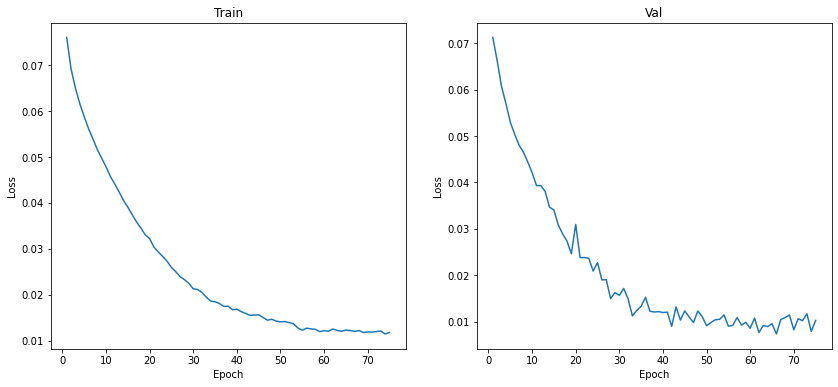

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(epochs, train_perceptual_loss)
axs[0].set_title('Train')
axs[1].plot(epochs, val_perceptual_loss)
axs[1].set_title('Val')

for ax in axs:
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')

## Training Metrics

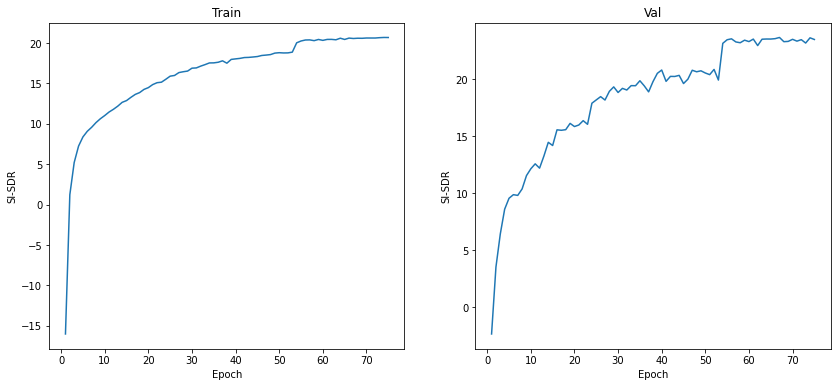

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(epochs, train_si_sdr)
axs[0].set_title('Train')
axs[1].plot(epochs, val_si_sdr)
axs[1].set_title('Val')

for ax in axs:
    ax.set_ylabel('SI-SDR')
    ax.set_xlabel('Epoch')

# Visualizing Results

In [7]:
with open(f'Configs/macaqueirmae.json') as f:
    data = f.read()
config = json.loads(data)

global dataset_config
dataset_config = config['dataset_config']

global encoder_config
encoder_config = config['model_config']['encoder_config']
global decoder_config
decoder_config = config['model_config']['decoder_config']
global autoencoder_config
autoencoder_config = config['model_config']

global learning_params
learning_params = config['learning_params']
global trainer_params
trainer_params = config['trainer_params']

## Loading Data

In [8]:
if dataset_config['name'] == 'Chirp':
    train_set = ChirpDataset(subset='train',
                             n_samples=dataset_config['n_train_samples'],
                             **dataset_config['signal_params'])
    val_set = ChirpDataset(subset='test',
                           n_samples=dataset_config['n_test_samples'],
                           **dataset_config['signal_params'])
elif dataset_config['name'] == 'Macaque':
    train_set = MacaqueDataset(subset='train')
    val_set = MacaqueDataset(subset='test')
elif dataset_config['name'] == 'ESC':
    train_set = ESCDataset(subset='train')
    val_set = ESCDataset(subset='test')
elif dataset_config['name'] == 'MusDB18':
    train_set = MusDB18Dataset(split='train',
                             n_samples=dataset_config['n_train_samples'],
                             **dataset_config['signal_params'])
    val_set = MusDB18Dataset(split='test',
                             n_samples=dataset_config['n_test_samples'],
                             **dataset_config['signal_params'])

train_loader = DataLoader(train_set,
                          batch_size=learning_params['batch_size'],
                          shuffle=True)
val_loader = DataLoader(val_set,
                        batch_size=learning_params['batch_size'],
                        shuffle=False)
example_data = next(iter(val_loader))
example_data[0].size()

torch.Size([16, 1, 24414])

## Loading the Model

In [9]:
if encoder_config['model_name'] == 'ToyConv':
    encoder = ToyConvEncoder(**encoder_config['model_params'])
elif encoder_config['model_name'] == 'Conv':
    encoder = ConvEncoder(**encoder_config['model_params'])
if encoder_config['model_name'] == 'ToyConvV0':
    encoder = ToyConvEncoderV0()

if decoder_config['model_name'] == 'ToyConv':
    decoder = ToyConvDecoder(**decoder_config['model_params'])
elif decoder_config['model_name'] == 'Conv':
    decoder = ConvDecoder(**decoder_config['model_params'])
elif decoder_config['model_name'] == 'ToyConvV0':
    decoder = ToyConvDecoderV0()

autoencoder = Autoencoder(encoder, 
                          decoder,
                          **autoencoder_config['model_params'])

/opt/conda/lib/python3.7/site-packages/torch/functional.py:581: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:639.)
  normalized, onesided, return_complex)


In [10]:
index = np.argmax(val_si_sdr)
ckpt = torch.load(f'MacaqueIRMAE/Checkpoints/ckpt{index}.pth.tar')
autoencoder.load_state_dict(ckpt['model_state_dict'])
autoencoder.eval()

Autoencoder(
  (encoder): ToyConvEncoder(
    (rep): STFT()
    (rep_padding): Padding1D()
    (conv1): Conv1d(612, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): ResidualBlock1d(
          (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (leaky_relu): LeakyReLU(negative_slope=0.01, inplace=True)
          (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Conv1d(128, 128, kernel_size=(4,), stride=(2,), padding=(1,))
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): LeakyReLU(negat

# Evaluating Performance

In [11]:
outputs = autoencoder(example_data[0])
x_hat, x = outputs, example_data[0]

/opt/conda/lib/python3.7/site-packages/torch/functional.py:655: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:787.)
  normalized, onesided, length, return_complex)


## Plotting Reconstructions

### Time Domain

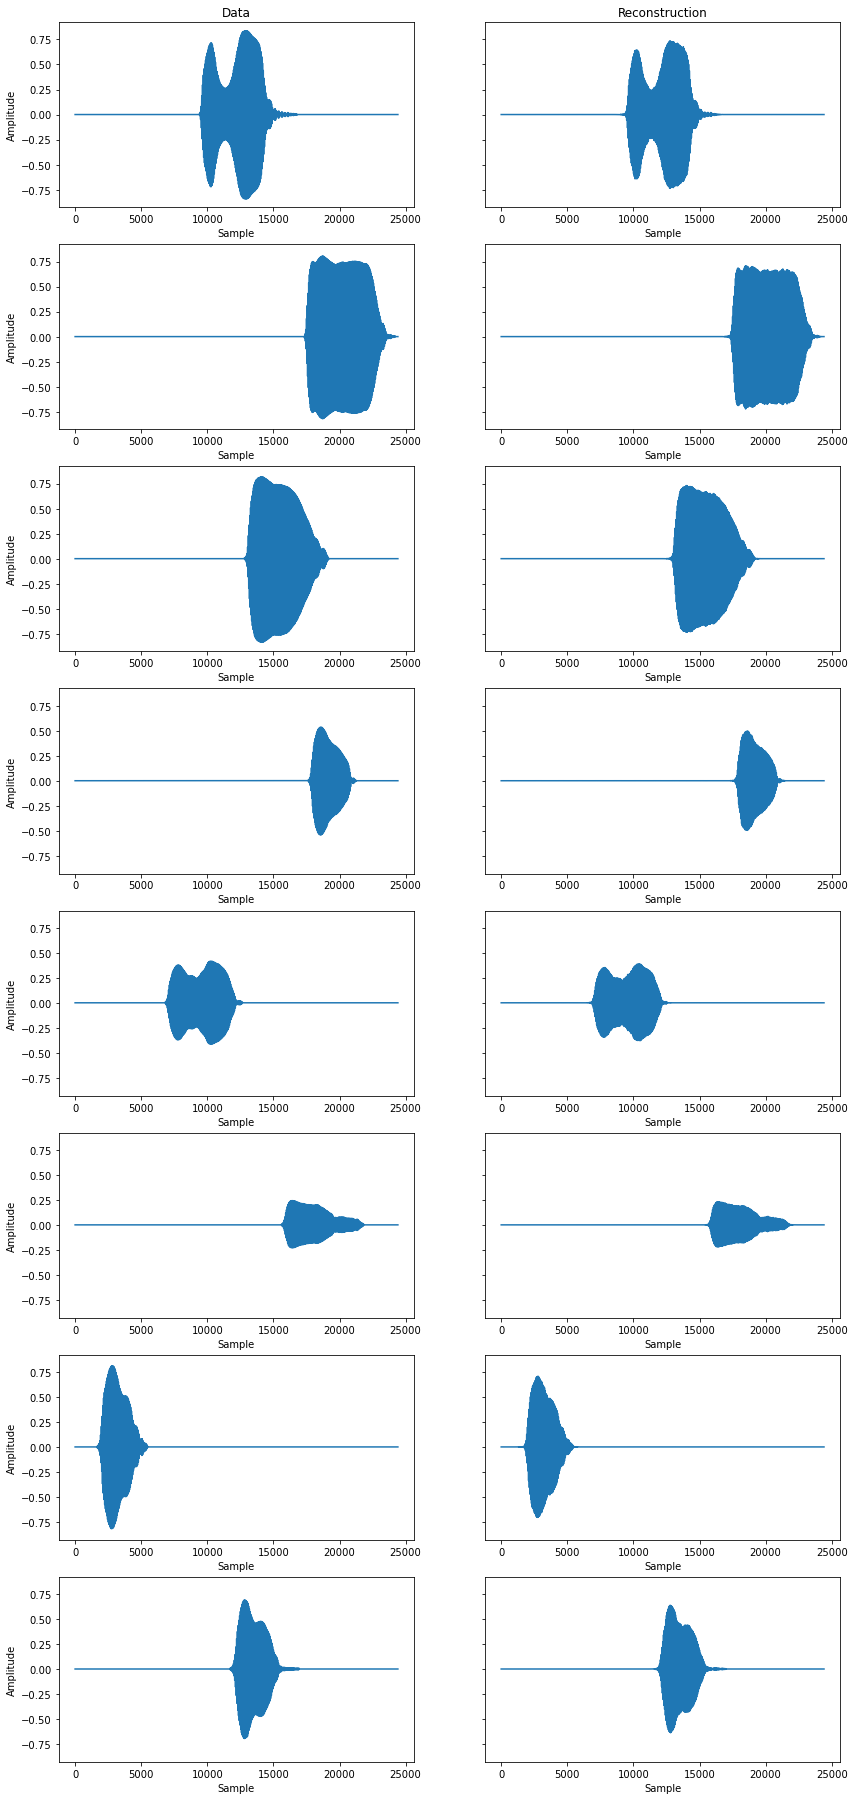

In [12]:
fig, axs = plt.subplots(8, 2, figsize=(14, 32), sharey=True)
for i in range(8):
    axs[i, 0].plot(x[i].squeeze().numpy())
    axs[i, 0].set_ylabel('Amplitude')
    axs[i, 0].set_xlabel('Sample')
    axs[i, 1].plot(x_hat[i].squeeze().detach().numpy())
    axs[i, 1].set_xlabel('Sample')
    if i == 0:
        axs[i, 0].set_title('Data')
        axs[i, 1].set_title('Reconstruction')
plt.show()

### Time-Frequency Domain

In [13]:
def gen_spec(x, sr=24414, win=25/1000, hop=10/1000):
    S = librosa.stft(x, n_fft=int(win*sr), hop_length=int(hop*sr))
    D = librosa.amplitude_to_db(np.abs(S), ref=1.)
    return D

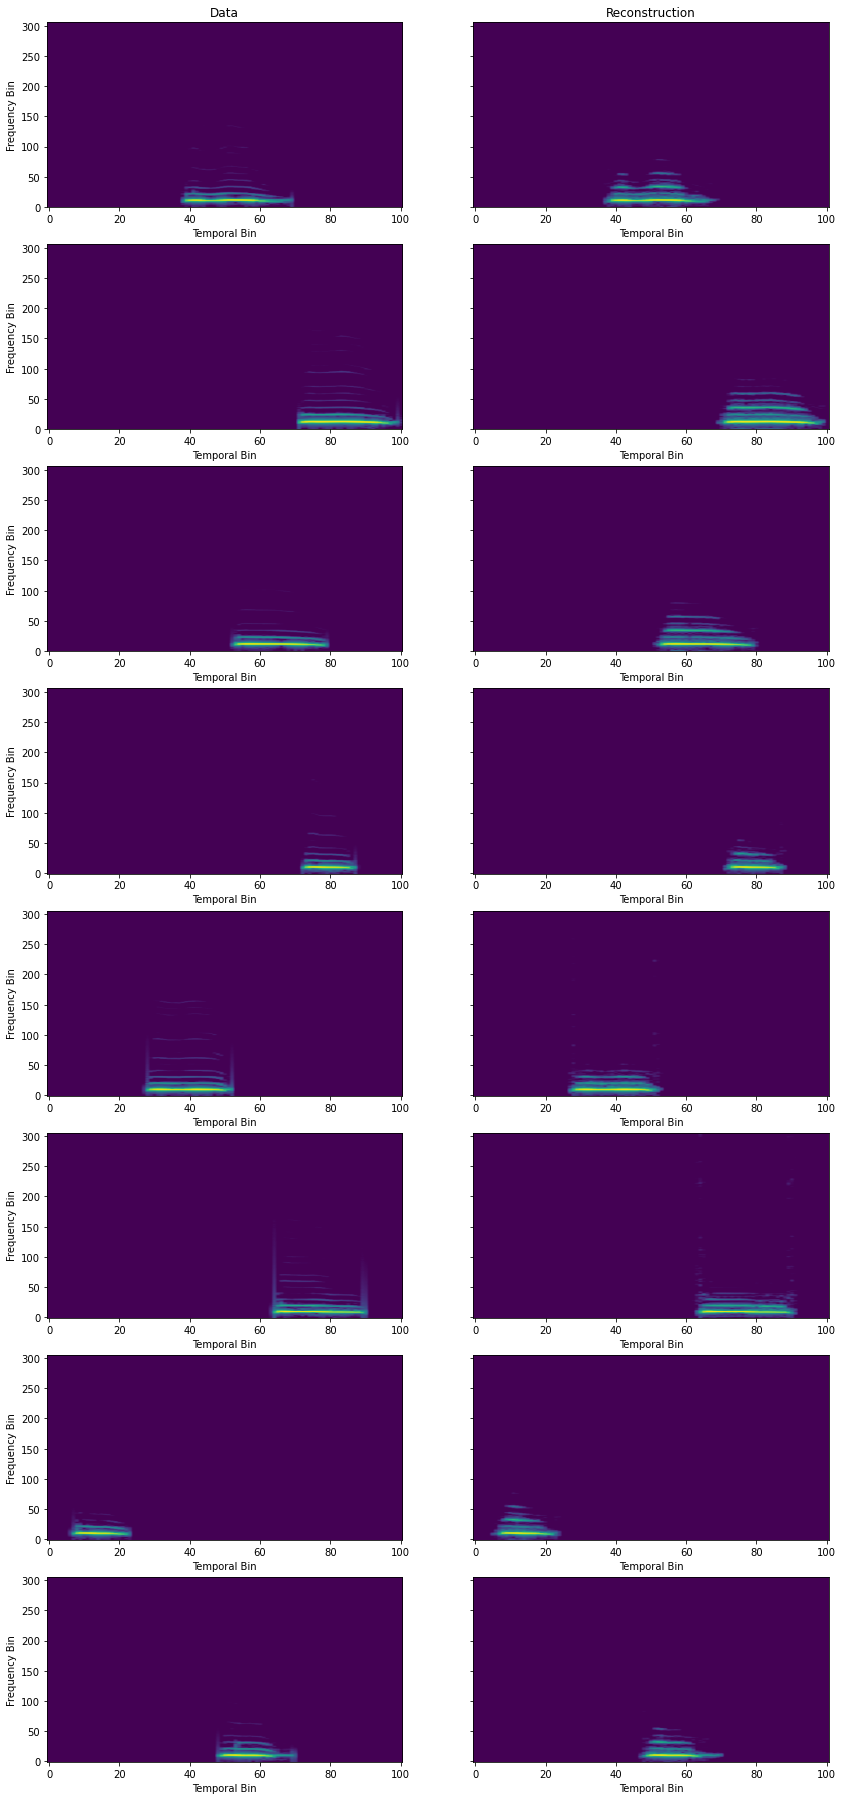

In [14]:
fig, axs = plt.subplots(8, 2, figsize=(14, 32), sharey=True)
for i in range(8):
    axs[i, 0].imshow(gen_spec(x[i].squeeze().numpy()), aspect='auto')
    axs[i, 0].invert_yaxis()
    axs[i, 0].set_ylabel('Frequency Bin')
    axs[i, 0].set_xlabel('Temporal Bin')
    axs[i, 1].imshow(gen_spec(x_hat[i].squeeze().detach().numpy()), aspect='auto')
    axs[i, 1].set_xlabel('Temporal Bin')
    axs[i, 1].invert_yaxis()
    if i == 0:
        axs[i, 0].set_title('Data')
        axs[i, 1].set_title('Reconstruction')
plt.show()

## Audio Reconstructions

In [15]:
for i in range(8):
    print('Data')
    display(Audio(x[i].squeeze().numpy(), rate=24414))
    print('Reconstruction')
    display(Audio(x_hat[i].squeeze().detach().numpy(), rate=24414))
    print()

Data


Reconstruction



Data


Reconstruction



Data


Reconstruction



Data


Reconstruction



Data


Reconstruction



Data


Reconstruction



Data


Reconstruction



Data


Reconstruction


# Interpolating

In [16]:
z = autoencoder.encode_to_latent(example_data[0])

In [17]:
z1 = z[0].unsqueeze(dim=0)
z2 = z[5].unsqueeze(dim=0)
decoder = autoencoder.decoder
decoder.eval()

ToyConvDecoder(
  (conv_linear): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (up_blocks): ModuleList(
    (0): Sequential(
      (0): ResidualBlock1d(
        (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky_relu): LeakyReLU(negative_slope=0.01, inplace=True)
        (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvTranspose1d(128, 128, kernel_size=(4,), stride=(2,), padding=(1,))
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): ResidualBlock1d(
        (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(128, eps=1e-05, mom

In [18]:
js = np.linspace(0, 1, 20)
recs = []
for j in js:
    z_int = j * z1 + (1 - j) * z2
    x_rec = decoder(z_int).detach()
    recs.append(x_rec)

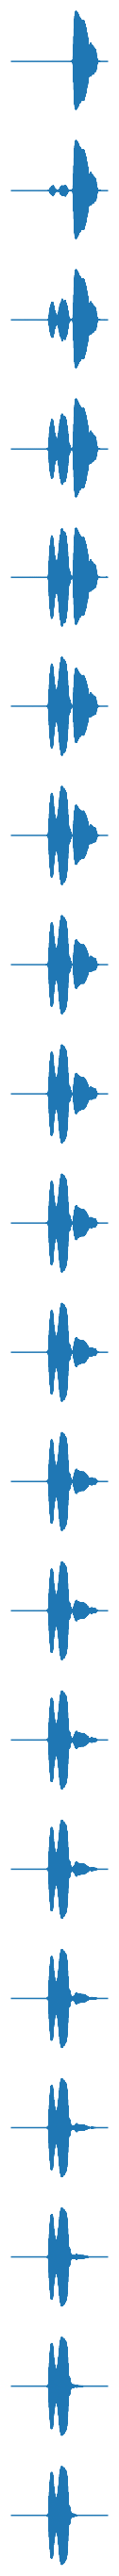

In [19]:
fig, axs = plt.subplots(20, 1, figsize=(2, 50))
for r, ax in zip(recs, axs):
    ax.plot(r.squeeze().numpy())
    ax.axis('off')
plt.show()

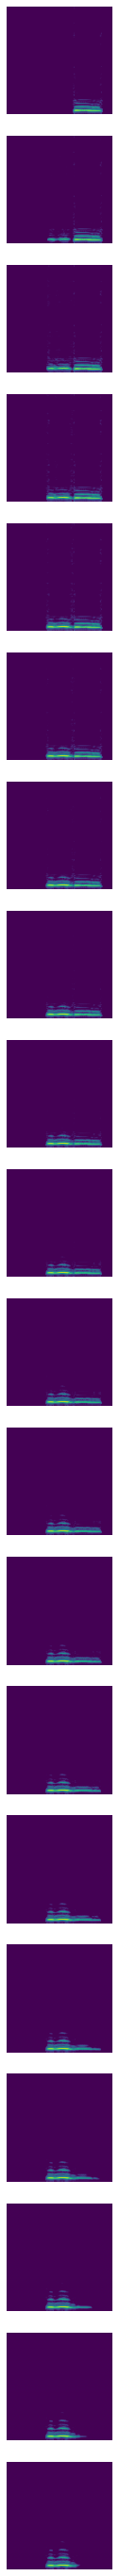

In [20]:
fig, axs = plt.subplots(20, 1, figsize=(2, 50))
for r, ax in zip(recs, axs):
    s = gen_spec(r.squeeze().numpy())
    ax.imshow(s, aspect='auto')
    ax.axis('off')
    ax.invert_yaxis()
plt.show()

In [21]:
for r, ax in zip(recs, axs):
    display(Audio(r.squeeze().numpy(), rate=24414))

# Generating

In [22]:
z.size()

torch.Size([16, 64, 51])

In [23]:
A =torch.tensor([[20., 1., 6.], [40., 2., 9.]]).unsqueeze(dim=0)
torch.mean(A, dim=1).size(), torch.std(A, dim=1)


(torch.Size([1, 3]), tensor([[14.1421,  0.7071,  2.1213]]))

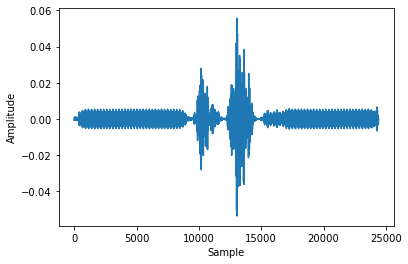

In [24]:
z_sample=torch.cat([torch.mean(z, dim=1).unsqueeze(dim=1) for _ in range(64)], dim=1)[0].unsqueeze(dim=0)

x_rec = decoder(z_sample).detach()
plt.plot(x_rec.squeeze().numpy())
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()
Audio(x_rec.squeeze().numpy(), rate=24414)

In [25]:
A = z[0]
B = A.mean(dim=0)
C = A.std(dim=0)
A.size(), B.size(), C.size()

(torch.Size([64, 51]), torch.Size([51]), torch.Size([51]))

In [26]:
vecs = []
for i in range(51):
    v = torch.distributions.normal.Normal(loc=B[i], scale=C[i], validate_args=None).sample(torch.randn(64).size()).unsqueeze(dim=1)
    vecs.append(v)
vecs = torch.hstack(vecs).unsqueeze(dim=0)
vecs.size()

torch.Size([1, 64, 51])

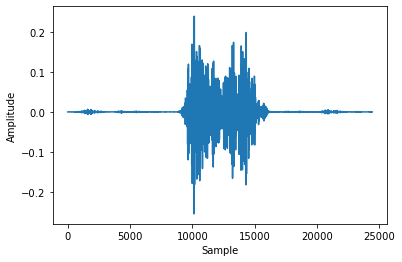

In [27]:
x_rec = decoder(vecs).detach()
plt.plot(x_rec.squeeze().numpy())
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()
Audio(x_rec.squeeze().numpy(), rate=24414)

In [28]:
zs = []
for yi, _ in val_loader:
    zi = autoencoder.encode_to_latent(yi).detach()
    zs.append(zi)
zs = torch.cat(zs, dim=0)
zs.shape

torch.Size([1457, 64, 51])

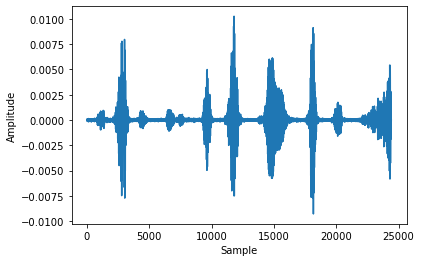

In [32]:
zs_mean = zs.mean(dim=0)
A = zs_mean
B = A.mean(dim=0)
C = A.std(dim=0)
samples = []
torch.manual_seed(42)
for j in range(100):
    vecs = []
    for i in range(51):
        v = torch.distributions.normal.Normal(loc=B[i], scale=C[i], validate_args=None).sample(torch.randn(64).size()).unsqueeze(dim=1)
        vecs.append(v)
    vecs = torch.hstack(vecs).unsqueeze(dim=0)
    samples.append(vecs)
x_rec = decoder(samples[0]).detach()
plt.plot(x_rec.squeeze().numpy())
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()
Audio((x_rec.squeeze().numpy()), rate=24414)